# 1. Нейросети

В учебниках по нейросетям часто рисуют картинки с нейронами головного мозга и сравнивают их с искусственными нейросетями. Однако это редко помогает понять логику того, как они действительно работают. Попробуем разобраться, что к чему.

## Перцептрон

Простейшая нейросеть - перцептрон - это линейный регрессор, результат которого подается в некоторую нелинейную функцию, называемую функцией активации. Нелинейность для функции активации - это обязательное требование, поскольку иначе всю модель можно будет свести к чистой линейной регресии, и именно благодаря этому требованию нейронки могут улавливать сложные нелинейные зависимости в данных.

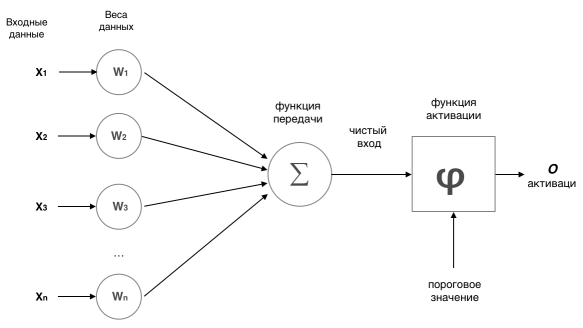

Похоже на одну из изученных вами ранее моделей, не правда ли? В рамках нашего курса вы уже использовали перцептрон, только в том задании он назывался логистической регрессией =)

Если мы будем соединять персептроны последовательно и параллельно, мы получим искусственную нейронную сеть. Работать с нейронкой нужно так же, как и с любой другой моделью машинного обучения: входные данные - это вектор признаков, выходные данные - это число или набор чисел. Также стоит заметить, что нейросети - это линейные модели, и подбор весов у них происходит практически так же, как и у линейной или логистической регрессии.

# 2. Кодирование изображений

Когда мы с вами работали с текстовыми данными, мы должны были преобразовать их в вектора чисел. Вообще говоря, в машинном обучении при работе с любой неструктурированной информацией нужно привести ее к тому виду, который готова воспринимать математическая модель - к вектору чисел. Разберемся, какими числами характеризуются изображения.

Прежде всего установим библиотеки, которые понадобятся нам для работы с нейронками:

- `keras` - высокоуровневый фреймворк работы с нейронными сетями. Пожалуй, он имеет самый низкий порог входа среди всех библиотек подобного рода, поэтому для нашего курса выбран именно он
- `tensorflow` - это одна из библиотек "бэкэнда" нейронных сетей. Это то, что keras будет использовать у себя "под капотом"



In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

Следующая команда покажет название видеокарты, подходящей для использования при обучении нейронок (если такой нет - ничего не выведет)

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

Видим, что видеокарта не подключена. Работая в Google Colab, мы можем подключить видеокарту с небольшим запасом бесплатного времени использования, выполнив несколько нехитрых действий. Для нашего задания необязательно использовать видеокарту, но потренироваться в ее использовании будет полезно.

Для того, чтобы подключить ядро с видеокартой, нам понадобится переключить окружение питона. Для этого нажмите `Среда выполнения -> Сменить среду выполнения` и там выберите Аппаратный ускоритель GPU.
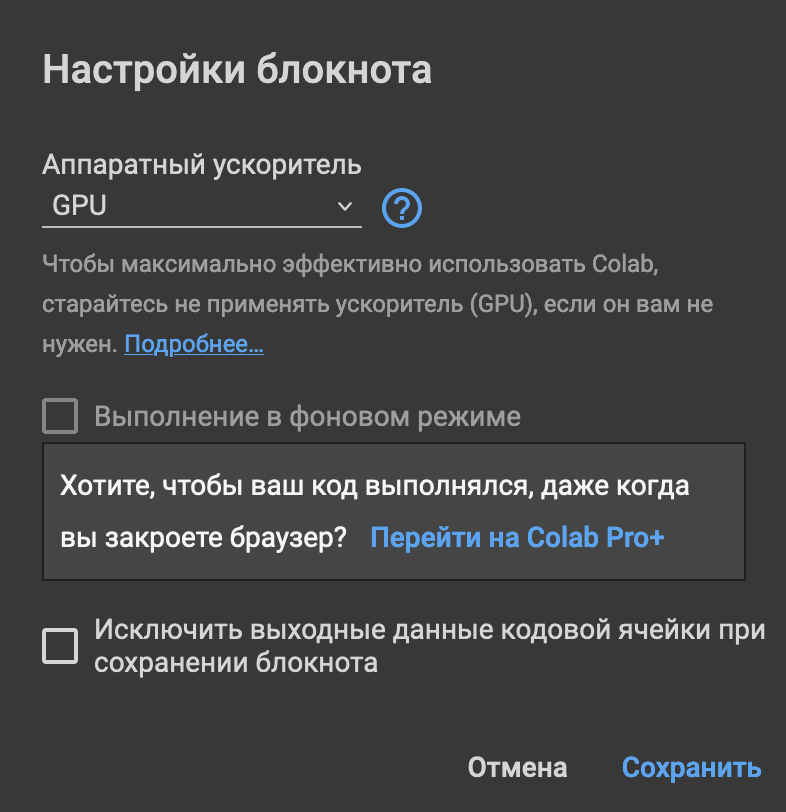

Теперь повторим код из предыдущей ячейки и увидим, что нам доступна видеокарта.

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

Уточним, используется ли сейас графический процессор:

In [ ]:
tf.test.gpu_device_name()

Если предыдущая ячейка вывела что-то вроде `/device:GPU:0`, то tensorflow использует видеокарту. Теперь начнем работу над нейронкой.

In [ ]:
import numpy as np
np.random.seed(123)                                           # для воспроизводимости
from keras.models import Sequential                           # Sequential - это базовый класс нейронки в керасе
from keras.layers import Dense, Dropout, Activation, Flatten  # дальше импортируем классы слоев
from keras.layers import Convolution2D, MaxPooling2D          # еще немного слоев, которые предназначены именно для работы с картинками
from keras.utils import np_utils
from keras.datasets import mnist                              # а это - классический набор картинок с рукописными цифрами, которые мы будем
                                                              # классифицировать в нашем примере

Загрузим предварительно перемешанные изображения из набора MNIST. Это изображения размером 8х8 пикселей, каждый пиксель закодирован интенсивностью черного цвета - от 0 до 255. Собственно, размер изображения 8х8 говорит нам о том, что каждую картинку мы можем описать вектором из 8х8=64 чисел, значения которых могут быть от 0 до 255, т.е. каждый объект описывается 64-мя признаками.

In [ ]:
(X_train, y_train), (X_test_raw, y_test) = mnist.load_data()

# посмотрим на одну из картинок
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[1])
plt.show()

# Приведем матричный вид изображений к тому, который сможет съесть керасовская модель 
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test_raw.reshape(X_test_raw.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


В нашем датасете 10 классов. При работе с нейронками мы не будем их кодировать одним числом, а проведем one-hot кодирование для класса каждого объекта. Т.е. y у нас будет не числом, а 10-мерным вектором:

In [ ]:
print("y_train:", y_train)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print("processed Y_train:", Y_train)

Построим архитектуру сети средствами библиотеки keras. Будем использовать полносвязные слои (когда каждый нейрон одного слоя связан с каждым нейроном соседнего слоя), слой свертки, макспуллинга, дропаут и уплощение.

In [ ]:
model = Sequential()

# свертка. Для первого слоя в сети нужно задать размер изображений, которые подаем в сеть
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
# для слоя пуллинга нужно задать количество пикселей по вертикали и горизонтали, по которым будет проводиться пуллинг,
# а также можно задать strides - смещение сетки
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25))
# сплющим полученный массив
model.add(Flatten())
# обычный полносвязный слой
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # у нас стоит задача десятиклассовой классификации, поэтому в выходном слое 10 нейронов

После того, как мы описали архитектуру сети, мы должны ее скомпилировать.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

А теперь самое время обучить нашу скомпилированную модель:

In [ ]:
scores = {}
for n_epochs in range(1, 10):  # эпоха - это этап дообучения сети. Чтобы не ждать бесконечно долго,
                               # можем прерваться на том этапе, на котором качество классификации будет
                               # достаточным для решения нашей задачи. Кстати, нейронки можно дообучать
                               # с конкретной эпохи, и тогда не придется каждый раз ждать, пока пройдет
                               # полное обучение. Такой подход продемонстрирован в следующей строке: задается аргумент initial_epoch
    model.fit(X_train, Y_train, batch_size=32, epochs=n_epochs, verbose=1, initial_epoch=n_epochs-1)
                               # в предыдущей строке важен аргумент batch_size - это количество картинок в одном
                               # "наборе" изображений, на который мы делим исходную выборку для ускорения обучения
    score = model.evaluate(X_test, Y_test, verbose=0)  # замеряем текущее качество классификации
    scores[n_epochs] = score  # сохраним текущее качество, чтобы построить график

# А теперь посмотрим, как менялось качество в процессе обучения нейронки
plt.plot(list(scores.keys()), list(map(lambda x: x[1], scores.values())))
plt.xlabel("Количество эпох")
plt.ylabel("Качество классификации")
plt.title("Качество классификации цифр в зависимости от количества эпох")
plt.show()

Попробуем предсказать, какое число изображено на картинке:

In [ ]:
plt.imshow(X_test_raw[25])
plt.show()

model.predict(np.expand_dims(X_test[25], axis=0))  # expand_dims здесь нужен потому, что model.predict, так же, как и fit,
                                                   # работает с батчами. Если мы хотим получить предсказание для одно картинки,
                                                   # мы должны подать батч из одного объекта

Сравним массив предсказаний с массивом верных ответов. Числа в предыдущей ячейке - это вероятности того, что объект принадлежит к определенному классу. Самая большая вероятность - у нулевого класса. В нижней ячейке видим, что модель в этом случае оказалась права

In [ ]:
Y_test[25]

# Подготовка к выполнению заданий

Датасет с картинками достаточно большой, поэтому было бы слишком накладно хранить его в гите. Скачаем архив с фотографиями для задания и разархивируем его в нашу рабочую папку.

In [ ]:
# загрузим архив с фотографиями во временную папку /tmp/ и назовем его dataset.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/dataset.zip

In [ ]:
import shutil
import zipfile

local_zip = '/tmp/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/tmp/dataset")
!mkdir dataset

from google.colab import drive
drive.mount('/content/drive')

!mv /tmp/dataset/cats_and_dogs_filtered/train/* /content/drive/MyDrive/data/train/
!mv /tmp/dataset/cats_and_dogs_filtered/validation/cats/* /content/drive/MyDrive/data/cats/
!mv /tmp/dataset/cats_and_dogs_filtered/validation/dogs/* /content/drive/MyDrive/data/dogs/
!rm -rf /tmp/dataset
!rm -rf /tmp/dataset.zip

# Задание 1. Готовим обучающую выборку

Нам требуется подготовить модель, которая разделяет фотографии на две категории, в зависимости от того, что на них нарисовано. Будем использовать сверточную нейросеть для этого.

У нас есть набор фотографий кошек и собак. Подготовим нейронку, которая будет уметь классифицировать фотографии на те, на которых изображена кошка, и те, на которых изображена собака.

Структура папки с фотографиями следующая:
```
dataset
|- cats
|- dogs
```
Разделите изображения на тренировочную и тестовую выборки в соотношении 80/20. Сохраните их в соответствии со следующей структурой папок:
```
dataset/animals
|- train
|  |- cats
|  |- dogs
|
|- test
|  |- cats
|  |- dogs
```
Сымитируем ситуацию, когда нам регулярно приходят новые изображения, и нам нужно дообучать модель. Поэтому для раскладывания картинок по папкам **нужно написать функцию**. Очищать исходные папки не нужно.

In [ ]:
def train_test_split_images(root_folder: str):
    """функция принимает аргумент - адрес корневой папку с изображениями,
    берет изображения из подпапок этой папки и раскладывает по папкам
    из описания задания"""
    # решение задания 1

В этой работе мы будем использовать нейросеть определенного типа - VGG19 с весами ResNet, параметры изображений для которой зададим заранее.

In [ ]:
import numpy as np
np.random.seed(123)  # для воспроизводимости
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import shutil

def train_test_split_images(str):
    """функция принимает аргумент - адрес корневой папку с изображениями, берет изображения из подпапок этой папки и раскладывает по папкам
    из описания задания"""
    try:
        dir = os.listdir(str)
        animals = dir.index('animals')
    except FileNotFoundError:
        print('Системе не удается найти указанный путь:', str)
        return -1
    except ValueError:
        os.mkdir(str + '/animals')
    try:
        os.mkdir(str + '/animals/test')
    except FileExistsError:
        animals_dirs = ''
    try:
        os.mkdir(str + '/animals/train')
    except FileExistsError:
        animals_dirs = ''
    try:
        cats = 0
        cats = dir.index('cats')
        try:
            os.mkdir(str + '/animals/test/cats')
        except FileExistsError:
            animals_dirs = ''
        try:
            os.mkdir(str + '/animals/train/cats')
        except FileExistsError:
            animals_dirs = ''
        dir_cats = os.listdir(str + '/cats')
        if len(dir_cats) == 0:
            dir_cats.index('12312dfsdfsdfsdfsdf')
        for i in range(0,len(dir_cats)):
            if i < len(dir_cats) * 0.8:
                shutil.copy(str + '/cats/' + dir_cats[i], str + '/animals/train/cats/')
            else:
                shutil.copy(str + '/cats/' + dir_cats[i], str + '/animals/test/cats/')
    except ValueError:
        print('Нет данных для обучения категории cats')
    try:
        dogs = 0
        dogs = dir.index('dogs')
        try:
            os.mkdir(str + '/animals/test/dogs')
        except FileExistsError:
            animals_dirs = ''
        try:
            os.mkdir(str + '/animals/train/dogs')
        except FileExistsError:
            animals_dirs = ''
        dir_dogs = os.listdir(str + '/dogs')
        if len(dir_dogs) == 0:
            dir_dogs.index('12312dfsdfsdfsdfsdf')
        for i in range(0,len(dir_dogs)):
            if i < len(dir_dogs) * 0.8:
                shutil.copy(str + '/dogs/' + dir_dogs[i], str + '/animals/train/dogs/' + dir_dogs[i])
            else:
                shutil.copy(str + '/dogs/' + dir_dogs[i], str + '/animals/test/dogs/' + dir_dogs[i])
    except ValueError:
        print('Нет данных для обучения категории dogs')
    if cats == 0 and dogs == 0:
        return -1
    return 0
print(train_test_split_images('/content/drive/MyDrive/data'))

В фотографиях, с которыми придется иметь дело нейросети, кошки и собаки могут быть абсолютно разные, сфотографированные под разными углами и с разной степенью приближения. Имея конечную тренировочную выборку, мы можем ее расширить, поворачивая и приближая имеющиеся изображения. В этом нам поможет класс [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # приведем значения пикселей к 0-1
    shear_range=0.2,   # максимальный угол поворота изображений
    zoom_range=0.2,    # максимальное приближение изображений
    horizontal_flip=True)  # используем повороты изображений для обогащения обучающей выборки

test_datagen = ImageDataGenerator(rescale=1. / 255)  # замер качества мы должны проводить на оригинальных изображениях, 
                                                     # поэтому тестовую выборку мы не будем вращать и приближать

Далее считаем изображения из папки, приведя их к тому размеру, с которым работает сеть VGG19. Кстати говоря, преимущество ImageDataGenerator'а в том, что картинки, разложенные по подпапкам, автоматически считаются объектами разных классов.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator =  # создайте генератор для тестовой выборки

# Задание 2. Переиспользование топологий нейронных сетей

Построим модель. Ваша задача - найти в интернете архитектуру VGG19 и описать нейросеть по этой архитектуре через keras. Рекомендую ориентироваться на архитектуру, описанную в официальном репозитории кераса на github.com. Ссылку на него здесь не приведена сознательно, поскольку большая часть работы программиста заключается в умении гуглить, и этот навык лучше тренировать сразу.

In [ ]:
import numpy as np
np.random.seed(123)  # для воспроизводимости
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

# размер для ResNet'a
img_width, img_height = 224, 224

# корневая папка
root_dir = r'/content/drive/MyDrive/data'  # введите сюда адрес корневой папки
# папка с тренировочными картинками
train_dir = os.path.join(root_dir, 'animals', 'train')
# и папка с тестовыми
test_dir = os.path.join(root_dir, 'animals', 'test')
# размер батча
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # приведем значения пикселей к 0-1
    shear_range=0.2,   # максимальный угол поворота изображений
    zoom_range=0.2,    # максимальное приближение изображений
    horizontal_flip=True)  # используем повороты изображений для обогащения обучающей выборки

test_datagen = ImageDataGenerator(rescale=1. / 255)  # замер качества мы должны проводить на оригинальных изображениях, 
                                                     # поэтому тестовую выборку мы не будем вращать и приближать
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

In [ ]:
def vlg_34():
    from keras import backend
    from keras.applications import imagenet_utils
    from keras.engine import training
    from keras.layers import VersionAwareLayers
    from keras.utils import data_utils
    layers = VersionAwareLayers()
    input_shape = imagenet_utils.obtain_input_shape(
        None,default_size=224,min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=True,weights='imagenet')
    img_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
    imagenet_utils.validate_activation('softmax', 'imagenet')
    x = layers.Dense(1000, activation='softmax',
                        name='predictions')(x)
    model2 = training.Model(img_input, x, name='vgg19')
    model2.load_weights(data_utils.get_file(
            'vgg19_weights_tf_dim_ordering_tf_kernels.h5',
            'https://storage.googleapis.com/tensorflow/keras-applications/'
                'vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5',
            cache_subdir='models',
            file_hash='cbe5617147190e668d6c5d5026f83318'))
    return model2
model = Sequential()
model.add(vlg_34())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
model.save_weights(os.path.join(root_dir,'vgg19_weights_tf_dim_ordering_tf_kernels.h5'))

Подгрузим веса модели, подобранные экспертами до нас. Если на предыдущем этапе вы создали неправильную архитектуру, следующая ячейка упадет с ошибкой.

In [ ]:
model.load_weights(os.path.join(root_dir, 'vgg19_weights_tf_dim_ordering_tf_kernels.h5'))

Осталось добавить полносвязный слой из двух нейронов (по количеству наших классов) с функцией активации softmax, чтобы наша модель могла производить бинарную классификацию изображений.
---
model.add()  # добавьте полносвязный слой, состоящий из двух нейронов, с функцией активации softmax


Скомпилируем и обучим сеть. Поскольку данные у нас теперь будут подаваться через генераторы, обучать модель нужно не методом fit, а методом fit_generator.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

# для примера обучим одну эпоху
model.fit_generator(
    train_generator,
    steps_per_epoch=250 // batch_size,
    epochs=1,
    workers=3)

# Задание 3. Обучение сети

Обучите 20 эпох сети, замеряя качество после каждой эпохи. Постройте график зависимости качества классификации от количества эпох сети. На какой эпохе качество модели превысит 0.45?

In [ ]:
log = model.fit(
    train_generator,
    steps_per_epoch=250 // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps= 250 // batch_size,
    workers=3)
acc_train = log.history['accuracy']
print(acc_train)
acc_test = log.history['val_accuracy']
print(acc_test)

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], acc_train)
plt.title('VGG19_train')
plt.show()
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], acc_test)
plt.title('VGG19_test')
plt.show()

# Задание 4. Готовые архитектуры нейросетей

В keras описаны некоторые популярные архитектуры нейросетей. При этом их можно использовать в качестве одного из слоев другой нейросети. В частности, есть готовый класс, в котором описана VGG19 с теми весами, которые мы подгружали из файла (ImageNet).

In [ ]:
from keras.applications.vgg19 import VGG19

ready_model = Sequential()
ready_model.add(VGG19(weights='imagenet'))
ready_model.add(Dense(2, activation='softmax')) 
ready_model.compile(optimizer='sgd', loss='categorical_crossentropy')

Изучите, какие нейросети также популярны для классификации изображений. Выберите 2 архитектуры, постройте модели с их использованием, выберите наилучшую по качеству на 20 эпохах и лучшую по скорости обучения.

In [ ]:
from keras.applications.resnet_v2 import ResNet152V2
m = Sequential()
m.add(ResNet152V2(weights='imagenet'))
m.add(Dense(2, activation='softmax')) 
m.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
m.save_weights(os.path.join(root_dir,'resnet_weights_tf_dim_ordering_tf_kernels.h5'))

In [ ]:
log1 = m.fit(
    train_generator,
    steps_per_epoch=250 // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps= 250 // batch_size,
    workers=3)
acc_train2 = log.history['accuracy']
print(acc_train2)
acc_test2 = log.history['val_accuracy']
print(acc_test2)

In [ ]:
acc_train2 = log1.history['accuracy']
acc_test2 = log1.history['val_accuracy']
print(acc_train2)
print(acc_test2)

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], acc_train2)
plt.title('ResNet152V2_train')
plt.show()
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], acc_test2)
plt.title('ResNet152V2_test')
plt.show()

In [ ]:
from keras.applications.densenet import DenseNet201
m2 = Sequential()
m2.add(DenseNet201(weights='imagenet'))
m2.add(Dense(2, activation='softmax')) 
m2.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
m2.save_weights(os.path.join(root_dir,'densenet201_weights_tf_dim_ordering_tf_kernels.h5'))

In [ ]:
log2 = m2.fit(
    train_generator,
    steps_per_epoch=250 // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps= 250 // batch_size,
    workers=3)
acc_train3 = log.history['accuracy']
print(acc_train3)
acc_test3 = log.history['val_accuracy']
print(acc_test3)

In [ ]:
acc_train3 = log2.history['accuracy']
acc_test3 = log2.history['val_accuracy']
print(acc_train3)
print(acc_test3)

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], acc_train3)
plt.title('ResNet152V2_train')
plt.show()
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], acc_test3)
plt.title('ResNet152V2_test')
plt.show()